In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import torch
from torch.utils.data import DataLoader
from model import EmoCatcher
from dataset import MyOwnDBMelS, emotion_dict
from dataloader import get_meta, split_meta, mels2batchMyOwn
from utils.evaluation import create_confusion_matrix, average_recall
from utils.evaluation import plot_cm, plot_metric_curve, plot_predicted_example
from tqdm import tqdm 

/run/media/viblab/Markov2/Pras/Thesis/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-11 10:42:21.925869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 10:42:40.393563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mel_kwargs = {"n_mels":80, "fmax": 8000, "win_length": 1024, "hop_length" : 256, "n_fft": 1024}
test_dset = MyOwnDBMelS("filelists/emotion_test_filelist.txt", mel_specs_kwargs=mel_kwargs)
test_dloader = DataLoader(test_dset, batch_size=64, collate_fn=mels2batchMyOwn, shuffle=False)

In [13]:
## best model path
#import glob
#model_path = glob.glob(f"./output/model/best_model*.pth")[0]

## load trained model
model = EmoCatcher(input_dim=80, hidden_dim=128, kernel_size=3, num_classes=5)
model.load_state_dict(torch.load('output/best_model_0.9204_0.4894.pth'))
model.eval()

EmoCatcher(
  (conv_block1): Conv1dLNBlock(
    (conv_block): Sequential(
      (0): Conv1d(80, 64, kernel_size=(3,), stride=(1,), padding=same)
      (1): ConvLN(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (2): GELU(approximate='none')
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (conv_block2): Conv1dLNBlock(
    (conv_block): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
      (1): ConvLN(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (2): GELU(approximate='none')
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (conv_block3): Conv1dLNBlock(
    (conv_block): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
      (1): ConvLN(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): GELU(approximate='none')
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (maxpool1): MaxPoo

In [37]:
total_ypred = np.array([])
total_zhid = np.array([])

for x_test, y_test, L in test_dloader:
    y_pred_test, z_hidden = model(x_test, L)
    y_pred_test = y_pred_test.argmax(dim = 1)

    total_ypred = np.concatenate([total_ypred, y_pred_test.cpu().detach().numpy()], axis=0)
    total_zhid = np.append(total_zhid, z_hidden.cpu().detach().numpy())
    #cm +=ConfusionMatrix( num_classes=n_class, task="multiclass" )(y_pred_test, y_test)

In [38]:
total_zhid = total_zhid.reshape(-1, 64)

In [39]:
total_ypred.shape

(4373,)

In [40]:
total_zhid.shape

(4373, 64)

In [41]:
from sklearn.manifold import TSNE

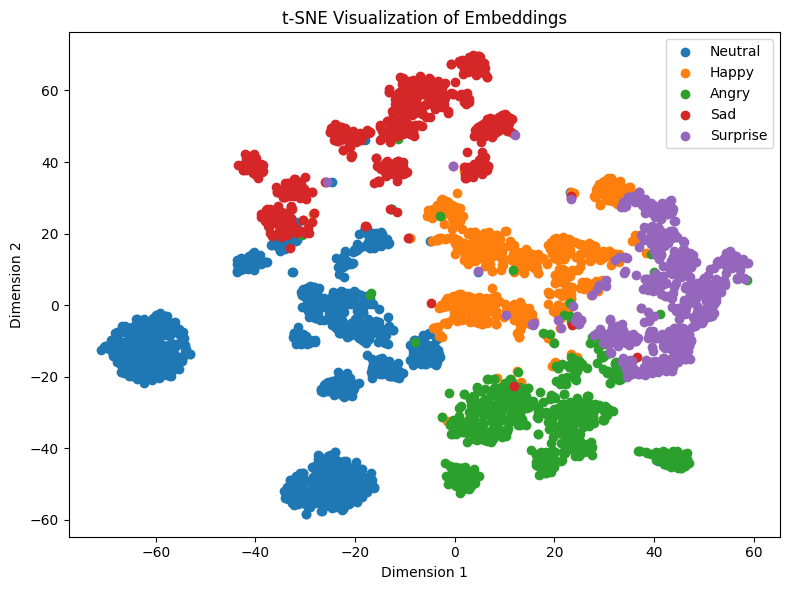

In [45]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(total_zhid)

plt.figure(figsize=(8, 6))
for label in np.unique(total_ypred):
    cluster_points = embeddings_2d[total_ypred == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=emotion_dict[label])

#plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], marker='o')
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
model.eval()
cm_test = create_confusion_matrix(model, test_dloader, n_class=5)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [7]:
print('Accuracy: {:.4f}'.format(cm_test.trace()/cm_test.sum() ))
print('UAR(Unweighted Average Recall): {:.4f}\nWAR(Weighted Average Recall): {:.4f}'.format(average_recall(cm_test, weighted=False), average_recall(cm_test, weighted=True)))

Accuracy: 0.9204
UAR(Unweighted Average Recall): 0.9121
WAR(Weighted Average Recall): 0.9204


In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10, 4), dpi = 100)
plot_cm(cm_test, normalize=True, ax = axes[0])
plot_cm(cm_test, normalize=False, ax = axes[1])
fig.suptitle('Test Accuracy: {:.4f}'.format(cm_test.trace()/ cm_test.sum()))
plt.tight_layout()
plt.savefig(f'./{holdout_outdir}/img/cm.jpg')